In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [2]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [3]:
true_theta = np.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_datasets = 200
n_samples = 500

In [4]:
actual_data = simulate_gandk(true_theta, n_samples)
actual_data

array([[ 3.18799398],
       [ 4.36241851],
       [ 4.50881472],
       [ 2.3908561 ],
       [ 8.85489607],
       [ 4.22026576],
       [ 2.82820541],
       [ 4.84332923],
       [ 2.37518878],
       [ 3.28546016],
       [ 2.98149124],
       [ 2.90626708],
       [ 2.76859544],
       [ 9.5016222 ],
       [12.57952534],
       [ 3.24393443],
       [ 3.44436586],
       [ 4.00182231],
       [ 2.7734596 ],
       [ 6.93721419],
       [ 4.51155113],
       [ 2.32595585],
       [ 2.91390163],
       [ 4.02745182],
       [ 3.83715165],
       [ 3.10049794],
       [ 2.74037159],
       [13.08854783],
       [ 3.6533086 ],
       [ 3.41768243],
       [ 5.17976888],
       [ 2.52870012],
       [ 3.08411733],
       [ 2.8355736 ],
       [ 4.20919597],
       [ 2.82077209],
       [ 2.36631065],
       [ 3.43963168],
       [ 2.4246762 ],
       [ 4.52669245],
       [ 3.38188101],
       [ 2.60783321],
       [ 2.55708176],
       [ 2.30258064],
       [ 3.29266683],
       [ 2

In [5]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([3.0564108 , 1.75306665, 0.47990734, 1.6010747 ])

In [6]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [7]:
actual_summary_statistics = np.array([2.96978227, 1.45609898, 0.4837584 , 2.00723605])

## Training Wasserstein Gaussianing

In [8]:
wass_num_datasets = 6000
wass_n_samples = 30
maxG = 4

In [9]:
wass_n_summary_statistics = np.zeros((wass_num_datasets, num_latent))
for i in range(0, wass_num_datasets):
    y = simulate_gandk(true_theta, wass_n_samples)
    wass_n_summary_statistics[i,:] = compute_summary_statistics(y)

In [10]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [11]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in range(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = int(np.argmin(bic_values) + 1)
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    mean_mixture_obj = best_mixture_obj.means_
    sigma_mixture_obj = best_mixture_obj.covariances_
    weights_mixture_obj = best_mixture_obj.weights_
    return best_mixture_obj, bestG, np.array(mean_mixture_obj), np.array(sigma_mixture_obj), np.array(weights_mixture_obj)

In [12]:
def grad_log_density_mixture(data, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj):
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,len(actual_summary_statistics))) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [13]:
# Start training

# Hyperparams
patience_max = 5
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = []
bestG_seq = []
lb = []
LB_Smoothed = []

# At current particles, fit mixture normal
mixture_model = mixture_model_fit(original_train_summary_statistics, maxG)
mixture_obj_seq.append(mixture_model[0])
bestG_seq.append(mixture_model[1])

In [14]:
for t in tqdm(range(stop)):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_model = mixture_model_fit(wass_train_summary_statistics, maxG)
    mixture_obj = mixture_model[0]
    bestG = mixture_model[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq.append(mixture_obj)
    bestG_seq.append(bestG)

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

  0%|                                                                                 | 1/5000 [00:00<16:47,  4.96it/s]

LB -7.302194588391296


  0%|                                                                                 | 3/5000 [00:00<16:58,  4.90it/s]

LB -6.0643931990288875
LB -5.577558360916104


  0%|                                                                                 | 5/5000 [00:01<16:27,  5.06it/s]

LB -5.2165300876072225
LB -4.8682346653514506


  0%|                                                                                 | 7/5000 [00:01<15:04,  5.52it/s]

LB -4.6055025377309216
LB -4.329527400449628


  0%|▏                                                                                | 9/5000 [00:01<14:04,  5.91it/s]

LB -4.0923342643877305
LB -3.8708313426990646


  0%|▏                                                                               | 11/5000 [00:02<13:58,  5.95it/s]

LB -3.6630099025325564
LB -3.4667669001658137


  0%|▏                                                                               | 13/5000 [00:02<14:48,  5.62it/s]

LB -3.3314720370290796
LB -3.1038168878211714


  0%|▏                                                                               | 14/5000 [00:02<14:08,  5.88it/s]

LB -2.9333594149608957


  0%|▏                                                                               | 15/5000 [00:02<15:09,  5.48it/s]

LB -2.7704270957690147


  0%|▎                                                                               | 16/5000 [00:02<16:13,  5.12it/s]

LB -2.6141298803153394


  0%|▎                                                                               | 17/5000 [00:03<17:12,  4.82it/s]

LB -2.4637472984597344


  0%|▎                                                                               | 19/5000 [00:03<16:59,  4.89it/s]

LB -2.3177893528725337
LB -2.177919144546092


  0%|▎                                                                               | 20/5000 [00:03<18:31,  4.48it/s]

LB -2.041996844801155


  0%|▎                                                                               | 21/5000 [00:04<22:10,  3.74it/s]

LB Smoothed -3.6583866640760214


  0%|▎                                                                               | 22/5000 [00:04<21:24,  3.88it/s]

LB Smoothed -3.442457686666877


  0%|▎                                                                               | 23/5000 [00:04<20:06,  4.13it/s]

LB Smoothed -3.242850093897384


  0%|▍                                                                               | 24/5000 [00:04<21:21,  3.88it/s]

LB Smoothed -3.054561761713512


  0%|▍                                                                               | 25/5000 [00:05<20:12,  4.10it/s]

LB Smoothed -2.8823485816144165


  1%|▍                                                                               | 27/5000 [00:05<18:20,  4.52it/s]

LB Smoothed -2.7140385646143836
LB Smoothed -2.5543912649329017


  1%|▍                                                                               | 29/5000 [00:05<16:54,  4.90it/s]

LB Smoothed -2.4015248898359394
LB Smoothed -2.2547660488492847


  1%|▍                                                                               | 31/5000 [00:06<15:09,  5.46it/s]

LB Smoothed -2.113540671748614
LB Smoothed -1.9784721461394186


  1%|▌                                                                               | 32/5000 [00:06<14:01,  5.90it/s]

LB Smoothed -1.8443008364325304


  1%|▌                                                                               | 34/5000 [00:06<16:04,  5.15it/s]

LB Smoothed -1.717111012109787
LB Smoothed -1.595429335169826


  1%|▌                                                                               | 35/5000 [00:07<16:58,  4.87it/s]

LB Smoothed -1.4761496326636225


  1%|▌                                                                               | 36/5000 [00:07<17:40,  4.68it/s]

LB Smoothed -1.3604568716034606


  1%|▌                                                                               | 38/5000 [00:07<17:29,  4.73it/s]

LB Smoothed -1.2481519042457532
LB Smoothed -1.1391102896812704


  1%|▋                                                                               | 40/5000 [00:08<14:55,  5.54it/s]

LB Smoothed -1.0331165456165967
LB Smoothed -0.9300644890176951


  1%|▋                                                                               | 41/5000 [00:08<17:14,  4.79it/s]

LB Smoothed -0.8271226697603343


  1%|▋                                                                               | 42/5000 [00:08<17:38,  4.69it/s]

LB Smoothed -0.7294641363198239


  1%|▋                                                                               | 43/5000 [00:08<17:36,  4.69it/s]

LB Smoothed -0.6355622159145559


  1%|▋                                                                               | 45/5000 [00:09<17:14,  4.79it/s]

LB Smoothed -0.5400807497221759
LB Smoothed -0.45077568279362107


  1%|▊                                                                               | 47/5000 [00:09<17:07,  4.82it/s]

LB Smoothed -0.36366926770399005
LB Smoothed -0.27868457070892755


  1%|▊                                                                               | 49/5000 [00:09<15:26,  5.35it/s]

LB Smoothed -0.19574933722778745
LB Smoothed -0.11479553190397525


  1%|▊                                                                               | 51/5000 [00:10<16:07,  5.12it/s]

LB Smoothed -0.034666251278304194
LB Smoothed 0.04251280592347651


  1%|▊                                                                               | 52/5000 [00:10<15:28,  5.33it/s]

LB Smoothed 0.11789292104747544


  1%|▊                                                                               | 54/5000 [00:11<16:47,  4.91it/s]

LB Smoothed 0.19294110747936669
LB Smoothed 0.26487900062832564


  1%|▉                                                                               | 55/5000 [00:11<17:31,  4.70it/s]

LB Smoothed 0.3351742676431703


  1%|▉                                                                               | 56/5000 [00:11<18:44,  4.39it/s]

LB Smoothed 0.4038742176720933


  1%|▉                                                                               | 58/5000 [00:11<16:50,  4.89it/s]

LB Smoothed 0.47102406495635857
LB Smoothed 0.5366670790527488


  1%|▉                                                                               | 59/5000 [00:12<17:23,  4.73it/s]

LB Smoothed 0.6008447199223488


  1%|▉                                                                               | 60/5000 [00:12<17:41,  4.66it/s]

LB Smoothed 0.6635967597746106


  1%|▉                                                                               | 61/5000 [00:12<17:58,  4.58it/s]

LB Smoothed 0.7249613932802275


  1%|█                                                                               | 63/5000 [00:12<16:57,  4.85it/s]

LB Smoothed 0.7849753375364942
LB Smoothed 0.8436739229761864


  1%|█                                                                               | 64/5000 [00:13<16:50,  4.88it/s]

LB Smoothed 0.9010911762487702


  1%|█                                                                               | 66/5000 [00:13<16:40,  4.93it/s]

LB Smoothed 0.9572598959656882
LB Smoothed 1.0122117220851128


  1%|█                                                                               | 68/5000 [00:13<16:49,  4.88it/s]

LB Smoothed 1.065977199612514
LB Smoothed 1.1185858372086994


  1%|█                                                                               | 69/5000 [00:14<18:17,  4.49it/s]

LB Smoothed 1.1700661612243932


  1%|█                                                                               | 70/5000 [00:14<18:02,  4.56it/s]

LB Smoothed 1.2204457656179553


  1%|█▏                                                                              | 71/5000 [00:14<18:44,  4.38it/s]

LB Smoothed 1.2697513581589521


  1%|█▏                                                                              | 72/5000 [00:14<19:19,  4.25it/s]

LB Smoothed 1.317125292894741


  1%|█▏                                                                              | 73/5000 [00:15<20:53,  3.93it/s]

LB Smoothed 1.3643623248847263


  1%|█▏                                                                              | 74/5000 [00:15<20:09,  4.07it/s]

LB Smoothed 1.4106004930905656


  2%|█▏                                                                              | 75/5000 [00:15<20:12,  4.06it/s]

LB Smoothed 1.4558633621391082


  2%|█▏                                                                              | 76/5000 [00:15<20:01,  4.10it/s]

LB Smoothed 1.5001737968399886


  2%|█▏                                                                              | 77/5000 [00:16<20:03,  4.09it/s]

LB Smoothed 1.543553992337302


  2%|█▏                                                                              | 78/5000 [00:16<22:20,  3.67it/s]

LB Smoothed 1.5860255023487606


  2%|█▎                                                                              | 79/5000 [00:16<21:53,  3.75it/s]

LB Smoothed 1.6245768693998404


  2%|█▎                                                                              | 80/5000 [00:17<21:06,  3.89it/s]

LB Smoothed 1.6637465009312578


  2%|█▎                                                                              | 81/5000 [00:17<21:08,  3.88it/s]

LB Smoothed 1.7035901831505205


  2%|█▎                                                                              | 82/5000 [00:17<20:20,  4.03it/s]

LB Smoothed 1.741516783473864


  2%|█▎                                                                              | 83/5000 [00:17<19:53,  4.12it/s]

LB Smoothed 1.7797153892332325


  2%|█▎                                                                              | 85/5000 [00:18<18:17,  4.48it/s]

LB Smoothed 1.817122866805523
LB Smoothed 1.853756938065355


  2%|█▍                                                                              | 86/5000 [00:18<18:28,  4.43it/s]

LB Smoothed 1.8896348567032581


  2%|█▍                                                                              | 88/5000 [00:18<17:21,  4.72it/s]

LB Smoothed 1.9247734248681752
LB Smoothed 1.9591890089537818


  2%|█▍                                                                              | 89/5000 [00:19<17:26,  4.69it/s]

LB Smoothed 1.9928975545884935


  2%|█▍                                                                              | 90/5000 [00:19<18:59,  4.31it/s]

LB Smoothed 2.0259146008838895


  2%|█▍                                                                              | 92/5000 [00:19<18:50,  4.34it/s]

LB Smoothed 2.0573648892416467
LB Smoothed 2.0890308940309725


  2%|█▍                                                                              | 93/5000 [00:19<18:25,  4.44it/s]

LB Smoothed 2.1200498546124917


  2%|█▌                                                                              | 95/5000 [00:20<17:27,  4.68it/s]

LB Smoothed 2.1504358118453517
LB Smoothed 2.180202461817485


  2%|█▌                                                                              | 97/5000 [00:20<17:27,  4.68it/s]

LB Smoothed 2.209363166563119
LB Smoothed 2.237930964314252


  2%|█▌                                                                              | 98/5000 [00:21<17:59,  4.54it/s]

LB Smoothed 2.2689509755666895


  2%|█▌                                                                              | 99/5000 [00:21<19:13,  4.25it/s]

LB Smoothed 2.296342455594919


  2%|█▌                                                                             | 101/5000 [00:21<18:11,  4.49it/s]

LB Smoothed 2.3218602390164196
LB Smoothed 2.349283878395013


  2%|█▌                                                                             | 102/5000 [00:21<16:31,  4.94it/s]

LB Smoothed 2.375093684621752


  2%|█▋                                                                             | 103/5000 [00:22<17:47,  4.59it/s]

LB Smoothed 2.4003822891772306


  2%|█▋                                                                             | 104/5000 [00:22<17:33,  4.65it/s]

LB Smoothed 2.4251607193170353


  2%|█▋                                                                             | 106/5000 [00:22<17:10,  4.75it/s]

LB Smoothed 2.44943974668897
LB Smoothed 2.4732298944274107


  2%|█▋                                                                             | 108/5000 [00:23<17:51,  4.56it/s]

LB Smoothed 2.496541443985212
LB Smoothed 2.51938444171654


  2%|█▋                                                                             | 109/5000 [00:23<18:11,  4.48it/s]

LB Smoothed 2.541768705223136


  2%|█▊                                                                             | 111/5000 [00:23<17:44,  4.59it/s]

LB Smoothed 2.5654777446045762
LB Smoothed 2.5869835356683066


  2%|█▊                                                                             | 113/5000 [00:24<16:07,  5.05it/s]

LB Smoothed 2.608058660067949
LB Smoothed 2.628712078814251


  2%|█▊                                                                             | 114/5000 [00:24<15:47,  5.16it/s]

LB Smoothed 2.648952552804178


  2%|█▊                                                                             | 116/5000 [00:24<16:07,  5.05it/s]

LB Smoothed 2.6687886479650476
LB Smoothed 2.688228740230227


  2%|█▊                                                                             | 117/5000 [00:25<15:46,  5.16it/s]

LB Smoothed 2.7072810203538893


  2%|█▉                                                                             | 119/5000 [00:25<16:20,  4.98it/s]

LB Smoothed 2.7275286042291556
LB Smoothed 2.7472006113986085


  2%|█▉                                                                             | 120/5000 [00:25<17:06,  4.76it/s]

LB Smoothed 2.7651473590668654


  2%|█▉                                                                             | 122/5000 [00:26<16:52,  4.82it/s]

LB Smoothed 2.7823652830126933
LB Smoothed 2.7996070261762593


  2%|█▉                                                                             | 123/5000 [00:26<17:28,  4.65it/s]

LB Smoothed 2.8165063694765013


  2%|█▉                                                                             | 125/5000 [00:26<17:23,  4.67it/s]

LB Smoothed 2.833070329860231
LB Smoothed 2.849305772643675


  3%|█▉                                                                             | 126/5000 [00:27<17:25,  4.66it/s]

LB Smoothed 2.8652194151494133


  3%|██                                                                             | 127/5000 [00:27<17:19,  4.69it/s]

LB Smoothed 2.880616157068071


  3%|██                                                                             | 128/5000 [00:27<18:09,  4.47it/s]

LB Smoothed 2.8959046319481545
LB Smoothed 2.9108906099937113


  3%|██                                                                             | 130/5000 [00:27<18:13,  4.45it/s]

LB Smoothed 2.9255802511844733


  3%|██                                                                             | 132/5000 [00:28<17:08,  4.73it/s]

LB Smoothed 2.9399795841655654
LB Smoothed 2.9540945093085362


  3%|██                                                                             | 133/5000 [00:28<17:15,  4.70it/s]

LB Smoothed 2.9679308016881247


  3%|██▏                                                                            | 135/5000 [00:28<16:59,  4.77it/s]

LB Smoothed 2.98149411397776
LB Smoothed 2.994789979266636


  3%|██▏                                                                            | 136/5000 [00:29<16:22,  4.95it/s]

LB Smoothed 3.0078238138010702


  3%|██▏                                                                            | 137/5000 [00:29<16:57,  4.78it/s]

LB Smoothed 3.020600919652736


  3%|██▏                                                                            | 138/5000 [00:29<17:23,  4.66it/s]

LB Smoothed 3.0331264873162516


  3%|██▏                                                                            | 139/5000 [00:29<17:31,  4.62it/s]

LB Smoothed 3.045405598238469


  3%|██▏                                                                            | 140/5000 [00:30<19:09,  4.23it/s]

LB Smoothed 3.0574091702683606


  3%|██▏                                                                            | 141/5000 [00:30<18:44,  4.32it/s]

LB Smoothed 3.0692088947018803


  3%|██▎                                                                            | 143/5000 [00:30<17:27,  4.64it/s]

LB Smoothed 3.0797805122604713
LB Smoothed 3.091116882266434


  3%|██▎                                                                            | 144/5000 [00:30<17:27,  4.64it/s]

LB Smoothed 3.1022307127521365


  3%|██▎                                                                            | 145/5000 [00:31<18:35,  4.35it/s]

LB Smoothed 3.113126479795972


  3%|██▎                                                                            | 146/5000 [00:31<18:56,  4.27it/s]

LB Smoothed 3.124010239572926


  3%|██▎                                                                            | 148/5000 [00:31<17:51,  4.53it/s]

LB Smoothed 3.13448408235146
LB Smoothed 3.1447527350337747


  3%|██▎                                                                            | 149/5000 [00:32<18:27,  4.38it/s]

LB Smoothed 3.1548203132299637


  3%|██▍                                                                            | 151/5000 [00:32<18:05,  4.47it/s]

LB Smoothed 3.1644355145206156
LB Smoothed 3.174114025752449


  3%|██▍                                                                            | 153/5000 [00:32<16:34,  4.88it/s]

LB Smoothed 3.1836032884395533
LB Smoothed 3.192907089046537


  3%|██▍                                                                            | 155/5000 [00:33<16:32,  4.88it/s]

LB Smoothed 3.202029136077344
LB Smoothed 3.2109730617631294


  3%|██▍                                                                            | 157/5000 [00:33<17:11,  4.70it/s]

LB Smoothed 3.2197424237099015
LB Smoothed 3.228340706507049


  3%|██▌                                                                            | 159/5000 [00:34<16:12,  4.98it/s]

LB Smoothed 3.236771323297867
LB Smoothed 3.2454436076482343


  3%|██▌                                                                            | 161/5000 [00:34<16:24,  4.92it/s]

LB Smoothed 3.2535487021261664
LB Smoothed 3.2624922338687425


  3%|██▌                                                                            | 163/5000 [00:35<16:15,  4.96it/s]

LB Smoothed 3.270289154924518
LB Smoothed 3.277934407164422


  3%|██▌                                                                            | 164/5000 [00:35<16:13,  4.97it/s]

LB Smoothed 3.2854310064724204


  3%|██▌                                                                            | 166/5000 [00:35<16:18,  4.94it/s]

LB Smoothed 3.292781907305603
LB Smoothed 3.299990003995096


  3%|██▋                                                                            | 167/5000 [00:35<15:28,  5.20it/s]

LB Smoothed 3.3070581320173176


  3%|██▋                                                                            | 168/5000 [00:36<15:43,  5.12it/s]

LB Smoothed 3.313989069236331


  3%|██▋                                                                            | 170/5000 [00:36<15:46,  5.11it/s]

LB Smoothed 3.32104087002136
LB Smoothed 3.32770446099856


  3%|██▋                                                                            | 172/5000 [00:36<15:07,  5.32it/s]

LB Smoothed 3.3342388786252726
LB Smoothed 3.340646681812421


  3%|██▋                                                                            | 174/5000 [00:37<16:22,  4.91it/s]

LB Smoothed 3.3469303776732566
LB Smoothed 3.3530924226068906


  4%|██▊                                                                            | 175/5000 [00:37<16:21,  4.91it/s]

LB Smoothed 3.359135223357736


  4%|██▊                                                                            | 176/5000 [00:37<18:02,  4.46it/s]

LB Smoothed 3.3650611380514435


  4%|██▊                                                                            | 177/5000 [00:37<19:24,  4.14it/s]

LB Smoothed 3.370872477207926


  4%|██▊                                                                            | 178/5000 [00:38<18:52,  4.26it/s]

LB Smoothed 3.375192670593411


  4%|██▊                                                                            | 180/5000 [00:38<17:42,  4.54it/s]

LB Smoothed 3.380779966184257
LB Smoothed 3.3854683692215644


  4%|██▊                                                                            | 181/5000 [00:38<16:50,  4.77it/s]

LB Smoothed 3.3908395863712086


  4%|██▉                                                                            | 182/5000 [00:39<18:23,  4.37it/s]

LB Smoothed 3.3961071531775673


  4%|██▉                                                                            | 183/5000 [00:39<19:25,  4.13it/s]

LB Smoothed 3.401273113927057


  4%|██▉                                                                            | 184/5000 [00:39<19:59,  4.02it/s]

LB Smoothed 3.406339471799388


  4%|██▉                                                                            | 186/5000 [00:40<17:41,  4.54it/s]

LB Smoothed 3.410087364646481
LB Smoothed 3.4149593870466517


  4%|██▉                                                                            | 187/5000 [00:40<17:54,  4.48it/s]

LB Smoothed 3.4197375883419205


  4%|██▉                                                                            | 188/5000 [00:40<18:31,  4.33it/s]

LB Smoothed 3.4244238155604485


  4%|██▉                                                                            | 189/5000 [00:40<18:53,  4.25it/s]

LB Smoothed 3.4290198786843358


  4%|███                                                                            | 191/5000 [00:41<17:46,  4.51it/s]

LB Smoothed 3.432255809373032
LB Smoothed 3.436674964093212


  4%|███                                                                            | 192/5000 [00:41<18:04,  4.43it/s]

LB Smoothed 3.4410091857724754


  4%|███                                                                            | 194/5000 [00:41<17:52,  4.48it/s]

LB Smoothed 3.444575930621221
LB Smoothed 3.448745203263382


  4%|███                                                                            | 195/5000 [00:42<16:52,  4.74it/s]

LB Smoothed 3.4528344515780165


  4%|███                                                                            | 196/5000 [00:42<17:25,  4.60it/s]

LB Smoothed 3.4568452465866946


  4%|███▏                                                                           | 198/5000 [00:42<16:41,  4.79it/s]

LB Smoothed 3.4621579620554512
LB Smoothed 3.4660180771408604


  4%|███▏                                                                           | 200/5000 [00:43<16:29,  4.85it/s]

LB Smoothed 3.47059523891049
LB Smoothed 3.4743113197238897


  4%|███▏                                                                           | 201/5000 [00:43<16:54,  4.73it/s]

LB Smoothed 3.4779562912866804


  4%|███▏                                                                           | 202/5000 [00:43<17:51,  4.48it/s]

LB Smoothed 3.4815315462623984


  4%|███▏                                                                           | 203/5000 [00:43<18:53,  4.23it/s]

LB Smoothed 3.485038449564934


  4%|███▏                                                                           | 204/5000 [00:44<19:48,  4.03it/s]

LB Smoothed 3.4896991639923733


  4%|███▏                                                                           | 205/5000 [00:44<19:42,  4.06it/s]

LB Smoothed 3.4930743295553497


  4%|███▎                                                                           | 206/5000 [00:44<19:57,  4.00it/s]

LB Smoothed 3.496385066792744


  4%|███▎                                                                           | 207/5000 [00:44<20:18,  3.93it/s]

LB Smoothed 3.499632635173429


  4%|███▎                                                                           | 209/5000 [00:45<18:13,  4.38it/s]

LB Smoothed 3.502153422357685
LB Smoothed 3.506549539794532


  4%|███▎                                                                           | 210/5000 [00:45<18:16,  4.37it/s]

LB Smoothed 3.50961625302144


  4%|███▎                                                                           | 211/5000 [00:45<19:22,  4.12it/s]

LB Smoothed 3.51262458456144


  4%|███▎                                                                           | 212/5000 [00:46<19:19,  4.13it/s]

LB Smoothed 3.5162598864848733


  4%|███▍                                                                           | 214/5000 [00:46<17:55,  4.45it/s]

LB Smoothed 3.519154906443094
LB Smoothed 3.521994893966751


  4%|███▍                                                                           | 215/5000 [00:46<17:42,  4.50it/s]

LB Smoothed 3.5247809216942882


  4%|███▍                                                                           | 216/5000 [00:46<17:57,  4.44it/s]

LB Smoothed 3.5275140410010364


  4%|███▍                                                                           | 217/5000 [00:47<18:46,  4.25it/s]

LB Smoothed 3.529317510247041


  4%|███▍                                                                           | 218/5000 [00:47<18:47,  4.24it/s]

LB Smoothed 3.5319485960368113


  4%|███▍                                                                           | 219/5000 [00:47<19:03,  4.18it/s]

LB Smoothed 3.5345297975336734


  4%|███▍                                                                           | 221/5000 [00:48<18:12,  4.37it/s]

LB Smoothed 3.536730468467565
LB Smoothed 3.5392148658789977


  4%|███▌                                                                           | 223/5000 [00:48<16:36,  4.80it/s]

LB Smoothed 3.5416522330397
LB Smoothed 3.544043484057879


  4%|███▌                                                                           | 224/5000 [00:48<16:40,  4.77it/s]

LB Smoothed 3.546389514968227


  4%|███▌                                                                           | 225/5000 [00:48<16:35,  4.80it/s]

LB Smoothed 3.54869120409476


  5%|███▌                                                                           | 227/5000 [00:49<16:29,  4.82it/s]

LB Smoothed 3.550949412406217
LB Smoothed 3.553829830630947


  5%|███▌                                                                           | 229/5000 [00:49<16:11,  4.91it/s]

LB Smoothed 3.5560041265456293
LB Smoothed 3.5581374131212464


  5%|███▋                                                                           | 230/5000 [00:49<16:49,  4.72it/s]

LB Smoothed 3.560230485514744


  5%|███▋                                                                           | 231/5000 [00:50<17:29,  4.54it/s]

LB Smoothed 3.5622841231954645


  5%|███▋                                                                           | 233/5000 [00:50<17:01,  4.67it/s]

LB Smoothed 3.5642990902591443
LB Smoothed 3.5662761357355


  5%|███▋                                                                           | 235/5000 [00:51<18:00,  4.41it/s]

LB Smoothed 3.568215993889547
LB Smoothed 3.570119384516791


  5%|███▋                                                                           | 236/5000 [00:51<17:47,  4.46it/s]

LB Smoothed 3.572864785413038


  5%|███▊                                                                           | 238/5000 [00:51<17:31,  4.53it/s]

LB Smoothed 3.574696631817566
LB Smoothed 3.5764940927872693


  5%|███▊                                                                           | 239/5000 [00:51<17:48,  4.45it/s]

LB Smoothed 3.5785894498632653


  5%|███▊                                                                           | 241/5000 [00:52<16:59,  4.67it/s]

LB Smoothed 3.580320048987524
LB Smoothed 3.5820182182292974


  5%|███▊                                                                           | 242/5000 [00:52<16:11,  4.90it/s]

LB Smoothed 3.5836845838137177


  5%|███▊                                                                           | 244/5000 [00:53<17:03,  4.64it/s]

LB Smoothed 3.58531975965269
LB Smoothed 3.5869243475902888


  5%|███▉                                                                           | 246/5000 [00:53<16:07,  4.91it/s]

LB Smoothed 3.5884989376431817
LB Smoothed 3.590044108236203


  5%|███▉                                                                           | 247/5000 [00:53<16:03,  4.93it/s]

LB Smoothed 3.5915604264331455


  5%|███▉                                                                           | 249/5000 [00:54<16:47,  4.72it/s]

LB Smoothed 3.5930484481629037
LB Smoothed 3.594508718441047


  5%|███▉                                                                           | 251/5000 [00:54<15:36,  5.07it/s]

LB Smoothed 3.595941771586917
LB Smoothed 3.5973481314363482


  5%|███▉                                                                           | 252/5000 [00:54<17:14,  4.59it/s]

LB Smoothed 3.598728311550089


  5%|███▉                                                                           | 253/5000 [00:54<17:10,  4.61it/s]

LB Smoothed 3.599453833845456


  5%|████                                                                           | 255/5000 [00:55<17:08,  4.61it/s]

LB Smoothed 3.600782571119643
LB Smoothed 3.602086614053578


  5%|████                                                                           | 257/5000 [00:55<16:29,  4.79it/s]

LB Smoothed 3.6033664371160827
LB Smoothed 3.6046225054799037


  5%|████                                                                           | 258/5000 [00:55<16:17,  4.85it/s]

LB Smoothed 3.6058552752062756


  5%|████                                                                           | 259/5000 [00:56<16:44,  4.72it/s]

LB Smoothed 3.6070651934257714


  5%|████                                                                           | 261/5000 [00:56<16:36,  4.76it/s]

LB Smoothed 3.6082526985155132
LB Smoothed 3.6094182202728233


  5%|████▏                                                                          | 263/5000 [00:57<15:36,  5.06it/s]

LB Smoothed 3.610562180085384
LB Smoothed 3.6116849910979845


  5%|████▏                                                                          | 264/5000 [00:57<14:43,  5.36it/s]

LB Smoothed 3.6127870583759156


  5%|████▏                                                                          | 266/5000 [00:57<15:11,  5.20it/s]

LB Smoothed 3.61386877906509
LB Smoothed 3.614930542548944


  5%|████▏                                                                          | 268/5000 [00:58<15:31,  5.08it/s]

LB Smoothed 3.6159727306021994
LB Smoothed 3.6169957175415366


  5%|████▎                                                                          | 270/5000 [00:58<14:29,  5.44it/s]

LB Smoothed 3.617999870373258
LB Smoothed 3.6189855489379785


  5%|████▎                                                                          | 271/5000 [00:58<14:07,  5.58it/s]

LB Smoothed 3.619953106052433
LB Smoothed 3.621531869221019


  5%|████▎                                                                          | 274/5000 [00:59<14:58,  5.26it/s]

LB Smoothed 3.6224647984487732
LB Smoothed 3.6233806195670506


  6%|████▎                                                                          | 275/5000 [00:59<17:29,  4.50it/s]

LB Smoothed 3.624279658652297


  6%|████▎                                                                          | 276/5000 [00:59<17:01,  4.63it/s]

LB Smoothed 3.624304123919067


  6%|████▍                                                                          | 278/5000 [01:00<17:06,  4.60it/s]

LB Smoothed 3.6251695412136713
LB Smoothed 3.6260191261872374


  6%|████▍                                                                          | 279/5000 [01:00<15:58,  4.92it/s]

LB Smoothed 3.626853180181113


  6%|████▍                                                                          | 280/5000 [01:00<17:36,  4.47it/s]

LB Smoothed 3.6276719986690265


  6%|████▍                                                                          | 281/5000 [01:00<17:16,  4.55it/s]

LB Smoothed 3.6284758713729253


  6%|████▍                                                                          | 283/5000 [01:01<16:36,  4.73it/s]

LB Smoothed 3.6292650823765022
LB Smoothed 3.6300399102364547


  6%|████▍                                                                          | 284/5000 [01:01<16:47,  4.68it/s]

LB Smoothed 3.6308006280915337


  6%|████▌                                                                          | 285/5000 [01:01<17:28,  4.50it/s]

LB Smoothed 3.6315475037694047


  6%|████▌                                                                          | 286/5000 [01:01<18:04,  4.35it/s]

LB Smoothed 3.631185476396838


  6%|████▌                                                                          | 288/5000 [01:02<16:52,  4.65it/s]

LB Smoothed 3.6319043454422424
LB Smoothed 3.6326101569323597


  6%|████▌                                                                          | 290/5000 [01:02<15:16,  5.14it/s]

LB Smoothed 3.633303158351084
LB Smoothed 3.6339835923754227


  6%|████▌                                                                          | 292/5000 [01:02<14:27,  5.42it/s]

LB Smoothed 3.634651696970225
LB Smoothed 3.6353077054810172


  6%|████▋                                                                          | 294/5000 [01:03<15:10,  5.17it/s]

LB Smoothed 3.635951846724994
LB Smoothed 3.636584345080199


  6%|████▋                                                                          | 295/5000 [01:03<16:25,  4.77it/s]

LB Smoothed 3.6380635320803085


  6%|████▋                                                                          | 297/5000 [01:04<15:39,  5.01it/s]

LB Smoothed 3.6386744111321776
LB Smoothed 3.639274285549766


  6%|████▋                                                                          | 298/5000 [01:04<15:40,  5.00it/s]

LB Smoothed 3.639863362871589


  6%|████▋                                                                          | 300/5000 [01:04<15:30,  5.05it/s]

LB Smoothed 3.640441846617377
LB Smoothed 3.6410099363670896


  6%|████▊                                                                          | 301/5000 [01:04<16:38,  4.71it/s]

LB Smoothed 3.641567827838357


  6%|████▊                                                                          | 303/5000 [01:05<16:13,  4.83it/s]

LB Smoothed 3.6421157129623967
LB Smoothed 3.6426537799584024


  6%|████▊                                                                          | 305/5000 [01:05<15:16,  5.12it/s]

LB Smoothed 3.643182213406477
LB Smoothed 3.644796517813659


  6%|████▊                                                                          | 307/5000 [01:06<15:17,  5.12it/s]

LB Smoothed 3.64530732874409
LB Smoothed 3.645809026771601


  6%|████▉                                                                          | 309/5000 [01:06<14:22,  5.44it/s]

LB Smoothed 3.6463017827467916
LB Smoothed 3.6467857642236807


  6%|████▉                                                                          | 310/5000 [01:06<14:43,  5.31it/s]

LB Smoothed 3.647261135524358


  6%|████▉                                                                          | 311/5000 [01:06<15:26,  5.06it/s]

LB Smoothed 3.647728057802347


  6%|████▉                                                                          | 313/5000 [01:07<15:16,  5.11it/s]

LB Smoothed 3.6481866891047288
LB Smoothed 3.648637184433019


  6%|████▉                                                                          | 315/5000 [01:07<14:55,  5.23it/s]

LB Smoothed 3.6490796958028473
LB Smoothed 3.649514372302457


  6%|████▉                                                                          | 316/5000 [01:07<13:44,  5.68it/s]

LB Smoothed 3.6499413601500423


  6%|█████                                                                          | 317/5000 [01:07<15:08,  5.15it/s]

LB Smoothed 3.650360802749956


  6%|█████                                                                          | 319/5000 [01:08<14:02,  5.56it/s]

LB Smoothed 3.6507728407477926
LB Smoothed 3.651177612084406


  6%|█████                                                                          | 320/5000 [01:08<14:51,  5.25it/s]

LB Smoothed 3.651575252048826


  6%|█████                                                                          | 322/5000 [01:08<15:37,  4.99it/s]

LB Smoothed 3.6519658933301584
LB Smoothed 3.6523496660684445


  6%|█████                                                                          | 324/5000 [01:09<14:49,  5.26it/s]

LB Smoothed 3.652726697904507
LB Smoothed 3.6530971140288355


  6%|█████▏                                                                         | 325/5000 [01:09<15:06,  5.16it/s]

LB Smoothed 3.653461037229478


  7%|█████▏                                                                         | 327/5000 [01:09<14:46,  5.27it/s]

LB Smoothed 3.6538185879390044
LB Smoothed 3.654169884280537


  7%|█████▏                                                                         | 329/5000 [01:10<14:13,  5.47it/s]

LB Smoothed 3.654515042112866
LB Smoothed 3.654854175074686


  7%|█████▏                                                                         | 330/5000 [01:10<15:38,  4.97it/s]

LB Smoothed 3.6551873946279456


  7%|█████▏                                                                         | 332/5000 [01:10<14:28,  5.38it/s]

LB Smoothed 3.6555148101003523
LB Smoothed 3.655836528727028


  7%|█████▎                                                                         | 334/5000 [01:11<13:00,  5.98it/s]

LB Smoothed 3.656152655691354
LB Smoothed 3.656463294165001


  7%|█████▎                                                                         | 336/5000 [01:11<13:07,  5.92it/s]

LB Smoothed 3.656768545347164
LB Smoothed 3.657068508503046


  7%|█████▎                                                                         | 338/5000 [01:11<11:59,  6.48it/s]

LB Smoothed 3.6573632810015555
LB Smoothed 3.6576529583522763


  7%|█████▎                                                                         | 340/5000 [01:12<11:22,  6.83it/s]

LB Smoothed 3.657937634241707
LB Smoothed 3.6582174005687764


  7%|█████▍                                                                         | 342/5000 [01:12<12:50,  6.05it/s]

LB Smoothed 3.658492347479672
LB Smoothed 3.6587625634019765


  7%|█████▍                                                                         | 344/5000 [01:12<13:50,  5.60it/s]

LB Smoothed 3.6590281350781253
LB Smoothed 3.6592891475982148


  7%|█████▍                                                                         | 346/5000 [01:13<13:52,  5.59it/s]

LB Smoothed 3.659545684432156
LB Smoothed 3.6597978274612024


  7%|█████▍                                                                         | 347/5000 [01:13<15:05,  5.14it/s]

LB Smoothed 3.6600456570088524


  7%|█████▍                                                                         | 348/5000 [01:13<16:17,  4.76it/s]

LB Smoothed 3.660289251871143


  7%|█████▌                                                                         | 350/5000 [01:14<16:08,  4.80it/s]

LB Smoothed 3.6605286893463465
LB Smoothed 3.6607640452640866


  7%|█████▌                                                                         | 351/5000 [01:14<16:15,  4.77it/s]

LB Smoothed 3.6609953940138755


  7%|█████▌                                                                         | 352/5000 [01:14<16:19,  4.74it/s]

LB Smoothed 3.6612228085730996


  7%|█████▌                                                                         | 354/5000 [01:14<16:09,  4.79it/s]

LB Smoothed 3.661446360534441
LB Smoothed 3.6616661201327676


  7%|█████▌                                                                         | 355/5000 [01:15<15:58,  4.85it/s]

LB Smoothed 3.661882156271495


  7%|█████▋                                                                         | 357/5000 [01:15<16:26,  4.71it/s]

LB Smoothed 3.6620945365484276
LB Smoothed 3.662303327281091


  7%|█████▋                                                                         | 358/5000 [01:15<18:37,  4.15it/s]

LB Smoothed 3.6625085935315673


  7%|█████▋                                                                         | 359/5000 [01:16<19:17,  4.01it/s]

LB Smoothed 3.662710399130839


  7%|█████▋                                                                         | 361/5000 [01:16<18:16,  4.23it/s]

LB Smoothed 3.6629088067026685
LB Smoothed 3.663103877686982


  7%|█████▋                                                                         | 362/5000 [01:16<19:37,  3.94it/s]

LB Smoothed 3.6632956723628225


  7%|█████▊                                                                         | 364/5000 [01:17<16:22,  4.72it/s]

LB Smoothed 3.66348424987083
LB Smoothed 3.6636696682352947


  7%|█████▊                                                                         | 366/5000 [01:17<14:21,  5.38it/s]

LB Smoothed 3.6638519843857678
LB Smoothed 3.664031254178254


  7%|█████▊                                                                         | 367/5000 [01:17<15:24,  5.01it/s]

LB Smoothed 3.664207532415987


  7%|█████▊                                                                         | 368/5000 [01:18<16:00,  4.82it/s]

LB Smoothed 3.664380872869787


  7%|█████▊                                                                         | 369/5000 [01:18<17:18,  4.46it/s]

LB Smoothed 3.6645513282980384


  7%|█████▊                                                                         | 370/5000 [01:18<17:12,  4.48it/s]

LB Smoothed 3.6647189504662587


  7%|█████▊                                                                         | 371/5000 [01:18<17:22,  4.44it/s]

LB Smoothed 3.664883790166289


  7%|█████▉                                                                         | 372/5000 [01:19<17:16,  4.47it/s]

LB Smoothed 3.665045897235112


  7%|█████▉                                                                         | 374/5000 [01:19<16:18,  4.73it/s]

LB Smoothed 3.6652053205732957
LB Smoothed 3.6653621081630727


  8%|█████▉                                                                         | 375/5000 [01:19<16:03,  4.80it/s]

LB Smoothed 3.6655163070860763


  8%|█████▉                                                                         | 377/5000 [01:19<14:43,  5.23it/s]

LB Smoothed 3.6656679635407206
LB Smoothed 3.6658171228592358


  8%|█████▉                                                                         | 378/5000 [01:20<14:12,  5.42it/s]

LB Smoothed 3.6659638295243835


  8%|██████                                                                         | 380/5000 [01:20<15:56,  4.83it/s]

LB Smoothed 3.66610812718583
LB Smoothed 3.666250058676211


  8%|██████                                                                         | 381/5000 [01:20<16:07,  4.77it/s]

LB Smoothed 3.6663896660268676
LB Smoothed 3.6665269904832942


  8%|██████                                                                         | 384/5000 [01:21<15:28,  4.97it/s]

LB Smoothed 3.6666620725202623
LB Smoothed 3.6667949518566623


  8%|██████                                                                         | 386/5000 [01:21<15:03,  5.11it/s]

LB Smoothed 3.6669256674700526
LB Smoothed 3.6670542576109177


  8%|██████                                                                         | 387/5000 [01:22<15:30,  4.96it/s]

LB Smoothed 3.6671807598166564


  8%|██████▏                                                                        | 388/5000 [01:22<16:49,  4.57it/s]

LB Smoothed 3.667305210925289


  8%|██████▏                                                                        | 390/5000 [01:22<15:47,  4.87it/s]

LB Smoothed 3.667427647088903
LB Smoothed 3.667548103786827


  8%|██████▏                                                                        | 392/5000 [01:23<14:35,  5.26it/s]

LB Smoothed 3.667666615838558
LB Smoothed 3.6677832174164258


  8%|██████▏                                                                        | 393/5000 [01:23<15:12,  5.05it/s]

LB Smoothed 3.6678979420580182


  8%|██████▏                                                                        | 395/5000 [01:23<15:06,  5.08it/s]

LB Smoothed 3.6680108226783577
LB Smoothed 3.6681218915818423


  8%|██████▎                                                                        | 397/5000 [01:24<14:38,  5.24it/s]

LB Smoothed 3.6682311804739562
LB Smoothed 3.6683387204727453


  8%|██████▎                                                                        | 399/5000 [01:24<15:05,  5.08it/s]

LB Smoothed 3.6684445421200738
LB Smoothed 3.6685486753926604


  8%|██████▎                                                                        | 400/5000 [01:24<14:49,  5.17it/s]

LB Smoothed 3.6686511497129004


  8%|██████▎                                                                        | 402/5000 [01:25<14:53,  5.15it/s]

LB Smoothed 3.668751993959466
LB Smoothed 3.66885123647772


  8%|██████▎                                                                        | 403/5000 [01:25<16:05,  4.76it/s]

LB Smoothed 3.668948905089907


  8%|██████▍                                                                        | 404/5000 [01:25<17:06,  4.48it/s]

LB Smoothed 3.6690450271051582


  8%|██████▍                                                                        | 406/5000 [01:26<16:46,  4.56it/s]

LB Smoothed 3.6691396293292917
LB Smoothed 3.669232738074433


  8%|██████▍                                                                        | 407/5000 [01:26<16:34,  4.62it/s]

LB Smoothed 3.6693243791684385


  8%|██████▍                                                                        | 408/5000 [01:26<17:25,  4.39it/s]

LB Smoothed 3.6694145779641376


  8%|██████▍                                                                        | 409/5000 [01:26<17:05,  4.48it/s]

LB Smoothed 3.6695033593484


  8%|██████▍                                                                        | 410/5000 [01:26<16:38,  4.60it/s]

LB Smoothed 3.6695907477510206


  8%|██████▍                                                                        | 411/5000 [01:27<17:08,  4.46it/s]

LB Smoothed 3.669676767153431


  8%|██████▌                                                                        | 413/5000 [01:27<16:15,  4.70it/s]

LB Smoothed 3.6697614410972474
LB Smoothed 3.6698447926926465


  8%|██████▌                                                                        | 414/5000 [01:27<15:58,  4.79it/s]

LB Smoothed 3.669926844626582


  8%|██████▌                                                                        | 416/5000 [01:28<16:08,  4.74it/s]

LB Smoothed 3.6700076191708377
LB Smoothed 3.670087138189929


  8%|██████▌                                                                        | 417/5000 [01:28<18:14,  4.19it/s]

LB Smoothed 3.6701654231488434


  8%|██████▌                                                                        | 418/5000 [01:28<17:38,  4.33it/s]

LB Smoothed 3.67024249512064


  8%|██████▋                                                                        | 420/5000 [01:29<16:34,  4.60it/s]

LB Smoothed 3.670318374793893
LB Smoothed 3.6703930824799955


  8%|██████▋                                                                        | 421/5000 [01:29<15:48,  4.83it/s]

LB Smoothed 3.670466638120319


  8%|██████▋                                                                        | 423/5000 [01:29<15:11,  5.02it/s]

LB Smoothed 3.670539061293237
LB Smoothed 3.6706103712210045


  8%|██████▋                                                                        | 425/5000 [01:30<15:42,  4.85it/s]

LB Smoothed 3.6706805867765158
LB Smoothed 3.6707497264899227


  9%|██████▋                                                                        | 427/5000 [01:30<15:38,  4.87it/s]

LB Smoothed 3.6708178085551246
LB Smoothed 3.670884850836136


  9%|██████▊                                                                        | 429/5000 [01:30<16:13,  4.70it/s]

LB Smoothed 3.670950870873329
LB Smoothed 3.671015885889556


  9%|██████▊                                                                        | 430/5000 [01:31<15:52,  4.80it/s]

LB Smoothed 3.6710799127961518


  9%|██████▊                                                                        | 431/5000 [01:31<16:32,  4.60it/s]

LB Smoothed 3.6711429681988177


  9%|██████▊                                                                        | 432/5000 [01:31<16:50,  4.52it/s]

LB Smoothed 3.6712050684034008


  9%|██████▊                                                                        | 433/5000 [01:31<16:40,  4.57it/s]

LB Smoothed 3.6712662294215477


  9%|██████▊                                                                        | 434/5000 [01:32<16:58,  4.48it/s]

LB Smoothed 3.6713264669762595


  9%|██████▊                                                                        | 435/5000 [01:32<16:45,  4.54it/s]

LB Smoothed 3.6713857965073373


  9%|██████▉                                                                        | 436/5000 [01:32<17:07,  4.44it/s]

LB Smoothed 3.671444233176713


  9%|██████▉                                                                        | 438/5000 [01:32<15:43,  4.83it/s]

LB Smoothed 3.671501791873698
LB Smoothed 3.671558487220101


  9%|██████▉                                                                        | 439/5000 [01:33<15:28,  4.91it/s]

LB Smoothed 3.6716143335752784


  9%|██████▉                                                                        | 440/5000 [01:33<16:33,  4.59it/s]

LB Smoothed 3.671669345041059
LB Smoothed 3.6717235354665942


  9%|██████▉                                                                        | 443/5000 [01:33<15:42,  4.83it/s]

LB Smoothed 3.671776918453104
LB Smoothed 3.6718295073585328


  9%|███████                                                                        | 445/5000 [01:34<15:24,  4.92it/s]

LB Smoothed 3.6718813153021195
LB Smoothed 3.6719323551688707


  9%|███████                                                                        | 447/5000 [01:34<15:53,  4.78it/s]

LB Smoothed 3.671982639613959
LB Smoothed 3.6720321810670273


  9%|███████                                                                        | 448/5000 [01:35<14:58,  5.07it/s]

LB Smoothed 3.6720809917364163


  9%|███████                                                                        | 449/5000 [01:35<15:45,  4.81it/s]

LB Smoothed 3.6721290836133016


  9%|███████▏                                                                       | 451/5000 [01:35<15:19,  4.94it/s]

LB Smoothed 3.6721764684757674
LB Smoothed 3.6722231578927778


  9%|███████▏                                                                       | 452/5000 [01:35<15:16,  4.96it/s]

LB Smoothed 3.6722691632281017


  9%|███████▏                                                                       | 453/5000 [01:36<17:18,  4.38it/s]

LB Smoothed 3.6723144956441294


  9%|███████▏                                                                       | 454/5000 [01:36<17:26,  4.34it/s]

LB Smoothed 3.6723591661056436


  9%|███████▏                                                                       | 455/5000 [01:36<18:36,  4.07it/s]

LB Smoothed 3.6724031853835015


  9%|███████▏                                                                       | 457/5000 [01:37<17:25,  4.35it/s]

LB Smoothed 3.6724465640582524
LB Smoothed 3.6724893125236804


  9%|███████▎                                                                       | 459/5000 [01:37<16:07,  4.70it/s]

LB Smoothed 3.672531440990291
LB Smoothed 3.672572959488714


  9%|███████▎                                                                       | 460/5000 [01:37<16:30,  4.58it/s]

LB Smoothed 3.6726138778730557


  9%|███████▎                                                                       | 462/5000 [01:38<15:17,  4.94it/s]

LB Smoothed 3.6726542058241756
LB Smoothed 3.6726939528529092


  9%|███████▎                                                                       | 464/5000 [01:38<13:36,  5.56it/s]

LB Smoothed 3.6727331283032267
LB Smoothed 3.6727717413553194


  9%|███████▎                                                                       | 465/5000 [01:38<15:06,  5.00it/s]

LB Smoothed 3.672809801028651


  9%|███████▍                                                                       | 467/5000 [01:39<15:32,  4.86it/s]

LB Smoothed 3.672847316184925
LB Smoothed 3.6728842955310124


  9%|███████▍                                                                       | 469/5000 [01:39<15:27,  4.89it/s]

LB Smoothed 3.6729207476218164
LB Smoothed 3.672956680863082


  9%|███████▍                                                                       | 470/5000 [01:39<13:37,  5.54it/s]

LB Smoothed 3.672992103514155


  9%|███████▍                                                                       | 471/5000 [01:39<14:30,  5.20it/s]

LB Smoothed 3.6730270236906857


  9%|███████▍                                                                       | 472/5000 [01:40<15:06,  5.00it/s]

LB Smoothed 3.6730614493672804


  9%|███████▍                                                                       | 473/5000 [01:40<16:00,  4.71it/s]

LB Smoothed 3.673095388380105


  9%|███████▍                                                                       | 474/5000 [01:40<16:45,  4.50it/s]

LB Smoothed 3.673128848429438


 10%|███████▌                                                                       | 476/5000 [01:40<15:47,  4.78it/s]

LB Smoothed 3.6731618370821697
LB Smoothed 3.6731943617742657


 10%|███████▌                                                                       | 477/5000 [01:41<15:03,  5.00it/s]

LB Smoothed 3.673226429813166


 10%|███████▌                                                                       | 478/5000 [01:41<15:46,  4.78it/s]

LB Smoothed 3.673258048380155


 10%|███████▌                                                                       | 479/5000 [01:41<16:25,  4.59it/s]

LB Smoothed 3.6732892245326787


 10%|███████▌                                                                       | 481/5000 [01:42<16:26,  4.58it/s]

LB Smoothed 3.6733199652066117
LB Smoothed 3.6733502772184976


 10%|███████▌                                                                       | 482/5000 [01:42<16:00,  4.70it/s]

LB Smoothed 3.6733801672677298


 10%|███████▋                                                                       | 483/5000 [01:42<17:12,  4.38it/s]

LB Smoothed 3.673409641938699


 10%|███████▋                                                                       | 484/5000 [01:42<17:27,  4.31it/s]

LB Smoothed 3.6734387077028967


 10%|███████▋                                                                       | 486/5000 [01:43<16:41,  4.51it/s]

LB Smoothed 3.6734673709209864
LB Smoothed 3.673495637844823


 10%|███████▋                                                                       | 488/5000 [01:43<16:42,  4.50it/s]

LB Smoothed 3.6735235146194434
LB Smoothed 3.6735510072850164


 10%|███████▋                                                                       | 489/5000 [01:43<16:14,  4.63it/s]

LB Smoothed 3.6735781217787515


 10%|███████▊                                                                       | 491/5000 [01:44<16:12,  4.64it/s]

LB Smoothed 3.673604863936782
LB Smoothed 3.6736312394959985


 10%|███████▊                                                                       | 492/5000 [01:44<17:04,  4.40it/s]

LB Smoothed 3.673657254095861


 10%|███████▊                                                                       | 493/5000 [01:44<16:57,  4.43it/s]

LB Smoothed 3.6736829132801625


 10%|███████▊                                                                       | 494/5000 [01:45<17:01,  4.41it/s]

LB Smoothed 3.6737082224987767


 10%|███████▊                                                                       | 496/5000 [01:45<16:02,  4.68it/s]

LB Smoothed 3.6737331871093546
LB Smoothed 3.6737578123790042


 10%|███████▊                                                                       | 497/5000 [01:45<15:00,  5.00it/s]

LB Smoothed 3.673782103485924


 10%|███████▊                                                                       | 498/5000 [01:45<14:51,  5.05it/s]

LB Smoothed 3.6738060655210174


 10%|███████▉                                                                       | 499/5000 [01:46<16:14,  4.62it/s]

LB Smoothed 3.6738297034894756


 10%|███████▉                                                                       | 501/5000 [01:46<15:52,  4.73it/s]

LB Smoothed 3.6738530223123202
LB Smoothed 3.6738760268279287


 10%|███████▉                                                                       | 503/5000 [01:46<15:29,  4.84it/s]

LB Smoothed 3.6738987217935226
LB Smoothed 3.6739211118866355


 10%|███████▉                                                                       | 505/5000 [01:47<15:16,  4.91it/s]

LB Smoothed 3.673943201706545
LB Smoothed 3.6739649957756826


 10%|███████▉                                                                       | 506/5000 [01:47<15:43,  4.77it/s]

LB Smoothed 3.673986498541019


 10%|████████                                                                       | 508/5000 [01:48<16:19,  4.59it/s]

LB Smoothed 3.674007714375415
LB Smoothed 3.6740286475789556


 10%|████████                                                                       | 510/5000 [01:48<15:24,  4.86it/s]

LB Smoothed 3.6740493023802574
LB Smoothed 3.6740696829377466


 10%|████████                                                                       | 511/5000 [01:48<14:08,  5.29it/s]

LB Smoothed 3.6740897933409173


 10%|████████                                                                       | 512/5000 [01:48<14:56,  5.00it/s]

LB Smoothed 3.6741096376115636


 10%|████████                                                                       | 513/5000 [01:48<15:26,  4.84it/s]

LB Smoothed 3.6741292197049935


 10%|████████                                                                       | 514/5000 [01:49<16:17,  4.59it/s]

LB Smoothed 3.674148543511212


 10%|████████▏                                                                      | 515/5000 [01:49<17:10,  4.35it/s]

LB Smoothed 3.67416761285609


 10%|████████▏                                                                      | 517/5000 [01:49<16:53,  4.42it/s]

LB Smoothed 3.6741864315025055
LB Smoothed 3.6742050031514673


 10%|████████▏                                                                      | 518/5000 [01:50<17:11,  4.34it/s]

LB Smoothed 3.6742233314432147


 10%|████████▏                                                                      | 520/5000 [01:50<16:35,  4.50it/s]

LB Smoothed 3.674241419958299
LB Smoothed 3.674259272218643


 10%|████████▏                                                                      | 521/5000 [01:50<17:02,  4.38it/s]

LB Smoothed 3.674276891688581


 10%|████████▏                                                                      | 522/5000 [01:51<16:52,  4.42it/s]

LB Smoothed 3.6742942817758815


 10%|████████▎                                                                      | 523/5000 [01:51<17:20,  4.30it/s]

LB Smoothed 3.674311445832746


 10%|████████▎                                                                      | 525/5000 [01:51<16:27,  4.53it/s]

LB Smoothed 3.6743283871567978
LB Smoothed 3.6743451089920383


 11%|████████▎                                                                      | 526/5000 [01:51<15:10,  4.92it/s]

LB Smoothed 3.674361614529803


 11%|████████▎                                                                      | 527/5000 [01:52<16:25,  4.54it/s]

LB Smoothed 3.6743779069096845


 11%|████████▎                                                                      | 528/5000 [01:52<16:57,  4.39it/s]

LB Smoothed 3.674393989220446


 11%|████████▎                                                                      | 530/5000 [01:52<15:59,  4.66it/s]

LB Smoothed 3.674409864500918
LB Smoothed 3.674425535740876


 11%|████████▍                                                                      | 532/5000 [01:53<14:55,  4.99it/s]

LB Smoothed 3.6744410058818997
LB Smoothed 3.6744562778182215


 11%|████████▍                                                                      | 533/5000 [01:53<14:12,  5.24it/s]

LB Smoothed 3.6744713543975567


 11%|████████▍                                                                      | 534/5000 [01:53<14:40,  5.07it/s]

LB Smoothed 3.6744862384219203


 11%|████████▍                                                                      | 536/5000 [01:54<14:43,  5.05it/s]

LB Smoothed 3.6745009326484204
LB Smoothed 3.6745154397900497


 11%|████████▍                                                                      | 537/5000 [01:54<15:30,  4.80it/s]

LB Smoothed 3.6745297625164532


 11%|████████▌                                                                      | 538/5000 [01:54<16:23,  4.54it/s]

LB Smoothed 3.6745439034546847


 11%|████████▌                                                                      | 540/5000 [01:54<15:35,  4.77it/s]

LB Smoothed 3.674557865189948
LB Smoothed 3.674571650266329


 11%|████████▌                                                                      | 541/5000 [01:55<15:53,  4.67it/s]

LB Smoothed 3.6745852611875045


 11%|████████▌                                                                      | 542/5000 [01:55<16:53,  4.40it/s]

LB Smoothed 3.6745987004174494


 11%|████████▌                                                                      | 543/5000 [01:55<17:22,  4.28it/s]

LB Smoothed 3.674611970381125


 11%|████████▌                                                                      | 544/5000 [01:55<16:54,  4.39it/s]

LB Smoothed 3.6746250734651498


 11%|████████▋                                                                      | 546/5000 [01:56<15:55,  4.66it/s]

LB Smoothed 3.6746380120184723
LB Smoothed 3.6746507883530133


 11%|████████▋                                                                      | 547/5000 [01:56<16:01,  4.63it/s]

LB Smoothed 3.6746634047443125


 11%|████████▋                                                                      | 548/5000 [01:56<16:01,  4.63it/s]

LB Smoothed 3.674675863432153


 11%|████████▋                                                                      | 550/5000 [01:57<15:27,  4.80it/s]

LB Smoothed 3.674688166621177
LB Smoothed 3.6747003164814913


 11%|████████▋                                                                      | 551/5000 [01:57<16:09,  4.59it/s]

LB Smoothed 3.6747123151492658


 11%|████████▋                                                                      | 553/5000 [01:57<16:02,  4.62it/s]

LB Smoothed 3.6747241647273055
LB Smoothed 3.6747358672856345


 11%|████████▊                                                                      | 555/5000 [01:58<15:25,  4.80it/s]

LB Smoothed 3.6747474248620513
LB Smoothed 3.6747588394626822


 11%|████████▊                                                                      | 557/5000 [01:58<14:38,  5.06it/s]

LB Smoothed 3.6747701130625225
LB Smoothed 3.674781247605968


 11%|████████▊                                                                      | 558/5000 [01:58<14:52,  4.98it/s]

LB Smoothed 3.6747922450073367


 11%|████████▊                                                                      | 560/5000 [01:59<14:27,  5.12it/s]

LB Smoothed 3.67480310715138
LB Smoothed 3.67481383589379


 11%|████████▊                                                                      | 561/5000 [01:59<14:40,  5.04it/s]

LB Smoothed 3.6748244330616893
LB Smoothed 3.6748349004541163


 11%|████████▉                                                                      | 564/5000 [01:59<14:17,  5.17it/s]

LB Smoothed 3.6748452398425027
LB Smoothed 3.6748554529711397


 11%|████████▉                                                                      | 565/5000 [02:00<14:44,  5.01it/s]

LB Smoothed 3.6748655415576397


 11%|████████▉                                                                      | 566/5000 [02:00<15:27,  4.78it/s]

LB Smoothed 3.6748755072933803


 11%|████████▉                                                                      | 567/5000 [02:00<15:38,  4.72it/s]

LB Smoothed 3.674885351843957


 11%|████████▉                                                                      | 568/5000 [02:00<15:52,  4.65it/s]

LB Smoothed 3.6748950768496074


 11%|████████▉                                                                      | 569/5000 [02:01<17:46,  4.15it/s]

LB Smoothed 3.6749046839256443


 11%|█████████                                                                      | 571/5000 [02:01<16:48,  4.39it/s]

LB Smoothed 3.6749141746628706
LB Smoothed 3.6749235506279976


 11%|█████████                                                                      | 572/5000 [02:01<16:39,  4.43it/s]

LB Smoothed 3.674932813364036


 11%|█████████                                                                      | 573/5000 [02:02<17:14,  4.28it/s]

LB Smoothed 3.6749419643907086


 11%|█████████                                                                      | 574/5000 [02:02<16:52,  4.37it/s]

LB Smoothed 3.6749510052048264


 12%|█████████                                                                      | 576/5000 [02:02<16:11,  4.55it/s]

LB Smoothed 3.674959937280678
LB Smoothed 3.674968762070403


 12%|█████████▏                                                                     | 578/5000 [02:03<14:34,  5.06it/s]

LB Smoothed 3.674977481004362
LB Smoothed 3.6749860954914966


 12%|█████████▏                                                                     | 580/5000 [02:03<15:03,  4.89it/s]

LB Smoothed 3.67499460691969
LB Smoothed 3.6750030166561083


 12%|█████████▏                                                                     | 581/5000 [02:03<16:50,  4.37it/s]

LB Smoothed 3.675011326047553


 12%|█████████▏                                                                     | 582/5000 [02:04<18:07,  4.06it/s]

LB Smoothed 3.6750195364207903


 12%|█████████▏                                                                     | 583/5000 [02:04<17:20,  4.24it/s]

LB Smoothed 3.6750276490828857


 12%|█████████▏                                                                     | 584/5000 [02:04<18:53,  3.89it/s]

LB Smoothed 3.6750356653215293


 12%|█████████▎                                                                     | 586/5000 [02:05<16:46,  4.38it/s]

LB Smoothed 3.6750435864053514
LB Smoothed 3.6750514135842436


 12%|█████████▎                                                                     | 587/5000 [02:05<17:05,  4.30it/s]

LB Smoothed 3.6750591480896575


 12%|█████████▎                                                                     | 588/5000 [02:05<17:05,  4.30it/s]

LB Smoothed 3.6750667911349133


 12%|█████████▎                                                                     | 590/5000 [02:05<16:13,  4.53it/s]

LB Smoothed 3.675074343915495
LB Smoothed 3.675081807609344


 12%|█████████▎                                                                     | 591/5000 [02:06<16:07,  4.56it/s]

LB Smoothed 3.6750891833771404


 12%|█████████▎                                                                     | 593/5000 [02:06<16:31,  4.44it/s]

LB Smoothed 3.6750964723625916
LB Smoothed 3.6751036756927054


 12%|█████████▍                                                                     | 594/5000 [02:06<16:11,  4.54it/s]

LB Smoothed 3.6751107944780617


 12%|█████████▍                                                                     | 596/5000 [02:07<16:02,  4.57it/s]

LB Smoothed 3.675117829813079
LB Smoothed 3.6751247827762783


 12%|█████████▍                                                                     | 597/5000 [02:07<15:37,  4.70it/s]

LB Smoothed 3.6751316544305364


 12%|█████████▍                                                                     | 598/5000 [02:07<16:30,  4.44it/s]

LB Smoothed 3.6751384458233494


 12%|█████████▍                                                                     | 599/5000 [02:07<16:15,  4.51it/s]

LB Smoothed 3.675145157987067


 12%|█████████▍                                                                     | 600/5000 [02:08<16:34,  4.42it/s]

LB Smoothed 3.6751517919391468


 12%|█████████▌                                                                     | 602/5000 [02:08<14:56,  4.90it/s]

LB Smoothed 3.6751583486823907
LB Smoothed 3.6751648292051815


 12%|█████████▌                                                                     | 604/5000 [02:08<14:44,  4.97it/s]

LB Smoothed 3.6751712344817125
LB Smoothed 3.67517756547222


 12%|█████████▌                                                                     | 605/5000 [02:09<15:27,  4.74it/s]

LB Smoothed 3.6751838231232


 12%|█████████▌                                                                     | 606/5000 [02:09<16:30,  4.44it/s]

LB Smoothed 3.675190008367633


 12%|█████████▌                                                                     | 607/5000 [02:09<16:22,  4.47it/s]

LB Smoothed 3.675196122125198


 12%|█████████▌                                                                     | 609/5000 [02:10<15:02,  4.86it/s]

LB Smoothed 3.6752021653024856
LB Smoothed 3.675208138793202


 12%|█████████▋                                                                     | 611/5000 [02:10<14:54,  4.91it/s]

LB Smoothed 3.67521404347838
LB Smoothed 3.675219880226578


 12%|█████████▋                                                                     | 613/5000 [02:10<14:06,  5.19it/s]

LB Smoothed 3.675225649894075
LB Smoothed 3.6752313533250667


 12%|█████████▋                                                                     | 615/5000 [02:11<13:07,  5.57it/s]

LB Smoothed 3.6752369913518588
LB Smoothed 3.6752425647950484


 12%|█████████▋                                                                     | 616/5000 [02:11<13:21,  5.47it/s]

LB Smoothed 3.6752480744637173


 12%|█████████▋                                                                     | 617/5000 [02:11<15:21,  4.76it/s]

LB Smoothed 3.675253521155603
LB Smoothed 3.6752589056572873


 12%|█████████▊                                                                     | 620/5000 [02:12<15:08,  4.82it/s]

LB Smoothed 3.6752642287443593
LB Smoothed 3.6752694911815995


 12%|█████████▊                                                                     | 621/5000 [02:12<16:05,  4.53it/s]

LB Smoothed 3.6752746937231393


 12%|█████████▊                                                                     | 622/5000 [02:12<15:56,  4.58it/s]

LB Smoothed 3.6752798371126345


 12%|█████████▊                                                                     | 624/5000 [02:13<14:55,  4.89it/s]

LB Smoothed 3.6752849220834207
LB Smoothed 3.6752899493586817


 12%|█████████▉                                                                     | 625/5000 [02:13<14:27,  5.04it/s]

LB Smoothed 3.6752949196516025


 13%|█████████▉                                                                     | 627/5000 [02:13<14:41,  4.96it/s]

LB Smoothed 3.675299833665523
LB Smoothed 3.675304692094098


 13%|█████████▉                                                                     | 629/5000 [02:14<13:51,  5.26it/s]

LB Smoothed 3.6753094956214363
LB Smoothed 3.6753142449222556


 13%|█████████▉                                                                     | 630/5000 [02:14<14:02,  5.19it/s]

LB Smoothed 3.6753189406620246


 13%|█████████▉                                                                     | 631/5000 [02:14<14:30,  5.02it/s]

LB Smoothed 3.675323583497107


 13%|█████████▉                                                                     | 632/5000 [02:14<16:49,  4.33it/s]

LB Smoothed 3.6753281740749


 13%|██████████                                                                     | 633/5000 [02:14<16:29,  4.41it/s]

LB Smoothed 3.675332713033968


 13%|██████████                                                                     | 634/5000 [02:15<16:10,  4.50it/s]

LB Smoothed 3.675337201004185


 13%|██████████                                                                     | 635/5000 [02:15<16:15,  4.47it/s]

LB Smoothed 3.6753416386068634


 13%|██████████                                                                     | 637/5000 [02:15<15:57,  4.55it/s]

LB Smoothed 3.675346026454886
LB Smoothed 3.675350365152831


 13%|██████████                                                                     | 639/5000 [02:16<14:53,  4.88it/s]

LB Smoothed 3.675354655297104
LB Smoothed 3.6753588974760554


 13%|██████████                                                                     | 640/5000 [02:16<15:28,  4.69it/s]

LB Smoothed 3.67536309227011


 13%|██████████▏                                                                    | 641/5000 [02:16<17:09,  4.24it/s]

LB Smoothed 3.6753672402518816


 13%|██████████▏                                                                    | 642/5000 [02:16<17:09,  4.23it/s]

LB Smoothed 3.6753713419862906


 13%|██████████▏                                                                    | 643/5000 [02:17<16:42,  4.35it/s]

LB Smoothed 3.6753753980306842


 13%|██████████▏                                                                    | 645/5000 [02:17<15:32,  4.67it/s]

LB Smoothed 3.6753794089349476
LB Smoothed 3.6753833752416174


 13%|██████████▏                                                                    | 647/5000 [02:17<14:17,  5.07it/s]

LB Smoothed 3.67538729748599
LB Smoothed 3.675391176196232


 13%|██████████▏                                                                    | 648/5000 [02:18<15:46,  4.60it/s]

LB Smoothed 3.675395011893486


 13%|██████████▎                                                                    | 650/5000 [02:18<15:23,  4.71it/s]

LB Smoothed 3.6753988050919766
LB Smoothed 3.675402556299113


 13%|██████████▎                                                                    | 652/5000 [02:19<14:14,  5.09it/s]

LB Smoothed 3.6754062660155866
LB Smoothed 3.6754099347354794


 13%|██████████▎                                                                    | 654/5000 [02:19<14:18,  5.06it/s]

LB Smoothed 3.675413562946355
LB Smoothed 3.6754171511293556


 13%|██████████▎                                                                    | 655/5000 [02:19<14:23,  5.03it/s]

LB Smoothed 3.6754206997592993


 13%|██████████▎                                                                    | 656/5000 [02:19<14:44,  4.91it/s]

LB Smoothed 3.675424209304777


 13%|██████████▍                                                                    | 657/5000 [02:20<15:55,  4.54it/s]

LB Smoothed 3.6754276802282324


 13%|██████████▍                                                                    | 658/5000 [02:20<16:26,  4.40it/s]

LB Smoothed 3.6754311129860655


 13%|██████████▍                                                                    | 660/5000 [02:20<15:38,  4.63it/s]

LB Smoothed 3.675434508028712
LB Smoothed 3.6754378658007396


 13%|██████████▍                                                                    | 662/5000 [02:21<14:07,  5.12it/s]

LB Smoothed 3.6754411867409247
LB Smoothed 3.6754444712823413


 13%|██████████▍                                                                    | 664/5000 [02:21<13:59,  5.16it/s]

LB Smoothed 3.675447719852444
LB Smoothed 3.675450932873154


 13%|██████████▌                                                                    | 666/5000 [02:21<13:40,  5.28it/s]

LB Smoothed 3.67545411076093
LB Smoothed 3.6754572539268553


 13%|██████████▌                                                                    | 667/5000 [02:22<13:55,  5.18it/s]

LB Smoothed 3.675460362776713


 13%|██████████▌                                                                    | 669/5000 [02:22<14:21,  5.03it/s]

LB Smoothed 3.675463437711065
LB Smoothed 3.67546647912532


 13%|██████████▌                                                                    | 670/5000 [02:22<14:45,  4.89it/s]

LB Smoothed 3.675469487409819


 13%|██████████▌                                                                    | 671/5000 [02:22<15:46,  4.57it/s]

LB Smoothed 3.6754724629498994


 13%|██████████▌                                                                    | 672/5000 [02:23<15:43,  4.59it/s]

LB Smoothed 3.6754754061259702
LB Smoothed 3.675478317313582


 14%|██████████▋                                                                    | 675/5000 [02:23<15:05,  4.78it/s]

LB Smoothed 3.675481196883499
LB Smoothed 3.675484045201762


 14%|██████████▋                                                                    | 676/5000 [02:23<14:24,  5.00it/s]

LB Smoothed 3.6754868626297603


 14%|██████████▋                                                                    | 677/5000 [02:24<15:19,  4.70it/s]

LB Smoothed 3.675489649524298
LB Smoothed 3.6754924062376584


 14%|██████████▋                                                                    | 679/5000 [02:24<14:42,  4.90it/s]

LB Smoothed 3.675495133117665


 14%|██████████▋                                                                    | 680/5000 [02:24<14:50,  4.85it/s]

LB Smoothed 3.6754978305077484


 14%|██████████▊                                                                    | 681/5000 [02:25<15:11,  4.74it/s]

LB Smoothed 3.6755004987470095


 14%|██████████▊                                                                    | 682/5000 [02:25<15:48,  4.55it/s]

LB Smoothed 3.675503138170275


 14%|██████████▊                                                                    | 684/5000 [02:25<15:54,  4.52it/s]

LB Smoothed 3.675505749108165
LB Smoothed 3.6755083318871473


 14%|██████████▊                                                                    | 685/5000 [02:25<15:21,  4.68it/s]

LB Smoothed 3.675510886829594


 14%|██████████▊                                                                    | 686/5000 [02:26<16:08,  4.46it/s]

LB Smoothed 3.675513414253846


 14%|██████████▊                                                                    | 687/5000 [02:26<15:47,  4.55it/s]

LB Smoothed 3.675515914474264


 14%|██████████▊                                                                    | 688/5000 [02:26<16:21,  4.39it/s]

LB Smoothed 3.6755183878012843


 14%|██████████▉                                                                    | 689/5000 [02:26<15:43,  4.57it/s]

LB Smoothed 3.6755208345414743


 14%|██████████▉                                                                    | 690/5000 [02:27<16:37,  4.32it/s]

LB Smoothed 3.675523254997591


 14%|██████████▉                                                                    | 691/5000 [02:27<16:06,  4.46it/s]

LB Smoothed 3.6755256494686237


 14%|██████████▉                                                                    | 692/5000 [02:27<17:54,  4.01it/s]

LB Smoothed 3.675528018249857


 14%|██████████▉                                                                    | 694/5000 [02:28<16:16,  4.41it/s]

LB Smoothed 3.675530361632917
LB Smoothed 3.6755326799058192


 14%|██████████▉                                                                    | 695/5000 [02:28<15:52,  4.52it/s]

LB Smoothed 3.675534973353025
LB Smoothed 3.675537242255488


 14%|███████████                                                                    | 697/5000 [02:28<14:48,  4.84it/s]

LB Smoothed 3.6755394868906968


 14%|███████████                                                                    | 698/5000 [02:28<15:28,  4.64it/s]

LB Smoothed 3.6755417075327323


 14%|███████████                                                                    | 699/5000 [02:29<16:34,  4.33it/s]

LB Smoothed 3.6755439044523084


 14%|███████████                                                                    | 701/5000 [02:29<15:24,  4.65it/s]

LB Smoothed 3.675546077916819
LB Smoothed 3.675548228190381


 14%|███████████                                                                    | 702/5000 [02:29<15:42,  4.56it/s]

LB Smoothed 3.675550355533886


 14%|███████████                                                                    | 703/5000 [02:30<15:49,  4.53it/s]

LB Smoothed 3.6755524602050387


 14%|███████████                                                                    | 704/5000 [02:30<16:14,  4.41it/s]

LB Smoothed 3.6755545424584


 14%|███████████▏                                                                   | 706/5000 [02:30<15:54,  4.50it/s]

LB Smoothed 3.675556602545433
LB Smoothed 3.675558640714543


 14%|███████████▏                                                                   | 707/5000 [02:30<15:38,  4.57it/s]

LB Smoothed 3.6755606572111166


 14%|███████████▏                                                                   | 708/5000 [02:31<15:55,  4.49it/s]

LB Smoothed 3.6755626522775686


 14%|███████████▏                                                                   | 709/5000 [02:31<15:45,  4.54it/s]

LB Smoothed 3.6755646261533763


 14%|███████████▏                                                                   | 710/5000 [02:31<16:27,  4.34it/s]

LB Smoothed 3.6755665790751206


 14%|███████████▏                                                                   | 712/5000 [02:31<14:56,  4.78it/s]

LB Smoothed 3.675568511276529
LB Smoothed 3.6755704229885056


 14%|███████████▎                                                                   | 714/5000 [02:32<14:01,  5.10it/s]

LB Smoothed 3.6755723144391785
LB Smoothed 3.675574185853929


 14%|███████████▎                                                                   | 715/5000 [02:32<15:19,  4.66it/s]

LB Smoothed 3.675576037455432


 14%|███████████▎                                                                   | 717/5000 [02:33<14:14,  5.01it/s]

LB Smoothed 3.6755778694636922
LB Smoothed 3.67557968209608


 14%|███████████▎                                                                   | 718/5000 [02:33<14:26,  4.94it/s]

LB Smoothed 3.675581475567363


 14%|███████████▍                                                                   | 720/5000 [02:33<13:53,  5.13it/s]

LB Smoothed 3.675583250089745
LB Smoothed 3.675585005872897


 14%|███████████▍                                                                   | 721/5000 [02:33<13:41,  5.21it/s]

LB Smoothed 3.675586743123992


 14%|███████████▍                                                                   | 722/5000 [02:33<14:03,  5.07it/s]

LB Smoothed 3.6755884620477386


 14%|███████████▍                                                                   | 723/5000 [02:34<14:23,  4.95it/s]

LB Smoothed 3.675590162846411


 14%|███████████▍                                                                   | 725/5000 [02:34<14:41,  4.85it/s]

LB Smoothed 3.6755918457198824
LB Smoothed 3.6755935108656583


 15%|███████████▍                                                                   | 726/5000 [02:34<14:12,  5.01it/s]

LB Smoothed 3.675595158478904


 15%|███████████▌                                                                   | 728/5000 [02:35<14:21,  4.96it/s]

LB Smoothed 3.6755967887524803
LB Smoothed 3.6755984018769645


 15%|███████████▌                                                                   | 730/5000 [02:35<14:31,  4.90it/s]

LB Smoothed 3.6755999980406933
LB Smoothed 3.675601577429782


 15%|███████████▌                                                                   | 731/5000 [02:35<15:01,  4.74it/s]

LB Smoothed 3.6756031402281524


 15%|███████████▌                                                                   | 732/5000 [02:36<15:59,  4.45it/s]

LB Smoothed 3.6756046866175716


 15%|███████████▌                                                                   | 733/5000 [02:36<16:16,  4.37it/s]

LB Smoothed 3.6756062167776684


 15%|███████████▌                                                                   | 734/5000 [02:36<16:00,  4.44it/s]

LB Smoothed 3.6756077308859703


 15%|███████████▌                                                                   | 735/5000 [02:36<17:27,  4.07it/s]

LB Smoothed 3.675609229117921


 15%|███████████▋                                                                   | 736/5000 [02:37<17:01,  4.18it/s]

LB Smoothed 3.6756107116469185


 15%|███████████▋                                                                   | 737/5000 [02:37<16:30,  4.30it/s]

LB Smoothed 3.6756121786443323


 15%|███████████▋                                                                   | 738/5000 [02:37<17:06,  4.15it/s]

LB Smoothed 3.675613630279533


 15%|███████████▋                                                                   | 740/5000 [02:38<16:00,  4.44it/s]

LB Smoothed 3.675615066719918
LB Smoothed 3.6756164881309386


 15%|███████████▋                                                                   | 741/5000 [02:38<16:09,  4.39it/s]

LB Smoothed 3.6756178946761193


 15%|███████████▋                                                                   | 743/5000 [02:38<14:54,  4.76it/s]

LB Smoothed 3.675619286517089
LB Smoothed 3.6756206638136013


 15%|███████████▊                                                                   | 744/5000 [02:38<14:56,  4.75it/s]

LB Smoothed 3.6756220267235578


 15%|███████████▊                                                                   | 746/5000 [02:39<14:26,  4.91it/s]

LB Smoothed 3.675623375403036
LB Smoothed 3.675624710006308


 15%|███████████▊                                                                   | 747/5000 [02:39<14:51,  4.77it/s]

LB Smoothed 3.6756260306858652


 15%|███████████▊                                                                   | 749/5000 [02:39<14:59,  4.72it/s]

LB Smoothed 3.6756273375924393
LB Smoothed 3.675628630875028


 15%|███████████▊                                                                   | 751/5000 [02:40<14:07,  5.02it/s]

LB Smoothed 3.6756299106809145
LB Smoothed 3.67563117715569


 15%|███████████▉                                                                   | 752/5000 [02:40<14:31,  4.88it/s]

LB Smoothed 3.675632430443271


 15%|███████████▉                                                                   | 754/5000 [02:40<14:40,  4.82it/s]

LB Smoothed 3.675633670685927
LB Smoothed 3.675634898024299


 15%|███████████▉                                                                   | 755/5000 [02:41<14:12,  4.98it/s]

LB Smoothed 3.6756361125974144


 15%|███████████▉                                                                   | 756/5000 [02:41<14:39,  4.83it/s]

LB Smoothed 3.6756373145427155


 15%|███████████▉                                                                   | 757/5000 [02:41<15:54,  4.45it/s]

LB Smoothed 3.675638503996072


 15%|███████████▉                                                                   | 758/5000 [02:41<16:16,  4.35it/s]

LB Smoothed 3.675639681091808


 15%|███████████▉                                                                   | 759/5000 [02:42<16:09,  4.37it/s]

LB Smoothed 3.675640845962715


 15%|████████████                                                                   | 760/5000 [02:42<15:58,  4.42it/s]

LB Smoothed 3.675641998740073


 15%|████████████                                                                   | 761/5000 [02:42<17:11,  4.11it/s]

LB Smoothed 3.6756431395536686


 15%|████████████                                                                   | 762/5000 [02:42<16:56,  4.17it/s]

LB Smoothed 3.675644268531818
LB Smoothed 3.6756453858013765


 15%|████████████                                                                   | 765/5000 [02:43<13:28,  5.24it/s]

LB Smoothed 3.6756464914877673
LB Smoothed 3.675647585714988


 15%|████████████                                                                   | 766/5000 [02:43<13:27,  5.24it/s]

LB Smoothed 3.6756486686056373


 15%|████████████▏                                                                  | 768/5000 [02:43<14:06,  5.00it/s]

LB Smoothed 3.675649740280927
LB Smoothed 3.6756508008607027


 15%|████████████▏                                                                  | 770/5000 [02:44<13:49,  5.10it/s]

LB Smoothed 3.675651850463455
LB Smoothed 3.675652889206342


 15%|████████████▏                                                                  | 771/5000 [02:44<14:29,  4.86it/s]

LB Smoothed 3.6756539172052034


 15%|████████████▏                                                                  | 773/5000 [02:44<14:22,  4.90it/s]

LB Smoothed 3.6756549345745744
LB Smoothed 3.6756559414277077


 16%|████████████▏                                                                  | 775/5000 [02:45<14:01,  5.02it/s]

LB Smoothed 3.6756569378765804
LB Smoothed 3.675657924031915


 16%|████████████▎                                                                  | 776/5000 [02:45<14:27,  4.87it/s]

LB Smoothed 3.675658900003198


 16%|████████████▎                                                                  | 777/5000 [02:45<14:48,  4.75it/s]

LB Smoothed 3.6756598658986848


 16%|████████████▎                                                                  | 778/5000 [02:46<15:27,  4.55it/s]

LB Smoothed 3.6756608218254256


 16%|████████████▎                                                                  | 779/5000 [02:46<16:08,  4.36it/s]

LB Smoothed 3.675661767889271


 16%|████████████▎                                                                  | 780/5000 [02:46<16:39,  4.22it/s]

LB Smoothed 3.675662704194894


 16%|████████████▎                                                                  | 782/5000 [02:47<16:04,  4.37it/s]

LB Smoothed 3.6756636308457975
LB Smoothed 3.675664547944333


 16%|████████████▍                                                                  | 784/5000 [02:47<14:06,  4.98it/s]

LB Smoothed 3.6756654555917123
LB Smoothed 3.6756663538880243


 16%|████████████▍                                                                  | 786/5000 [02:47<14:46,  4.75it/s]

LB Smoothed 3.6756672429322426
LB Smoothed 3.6756681228222434


 16%|████████████▍                                                                  | 787/5000 [02:47<14:02,  5.00it/s]

LB Smoothed 3.675668993654819


 16%|████████████▍                                                                  | 788/5000 [02:48<15:22,  4.57it/s]

LB Smoothed 3.675669855525687


 16%|████████████▍                                                                  | 789/5000 [02:48<16:17,  4.31it/s]

LB Smoothed 3.6752043135556405


 16%|████████████▍                                                                  | 790/5000 [02:48<17:06,  4.10it/s]

LB Smoothed 3.6752049249562155


 16%|████████████▍                                                                  | 791/5000 [02:49<17:42,  3.96it/s]

LB Smoothed 3.675205532051154


 16%|████████████▌                                                                  | 792/5000 [02:49<17:52,  3.92it/s]

LB Smoothed 3.67520613484694


 16%|████████████▌                                                                  | 793/5000 [02:49<15:00,  4.67it/s]

LB Smoothed 3.6752067333507363
LB Smoothed 3.6752073275703676
Stop at 793


<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

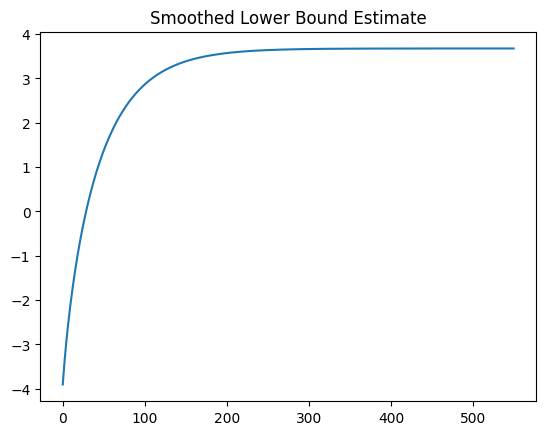

In [14]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

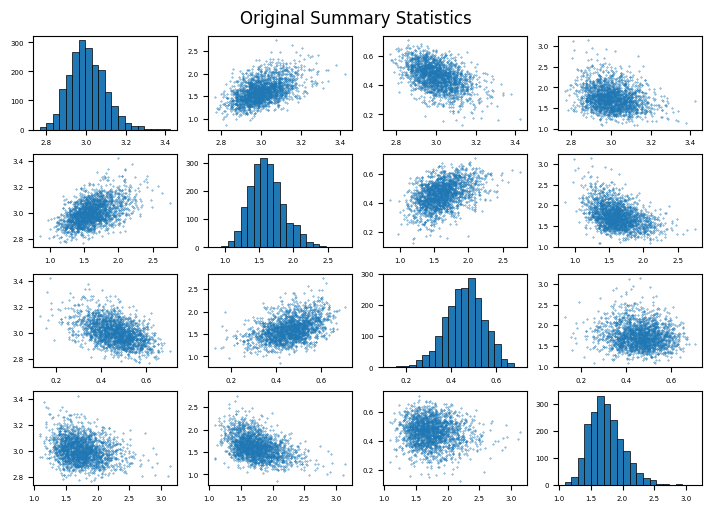

In [62]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x], original_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


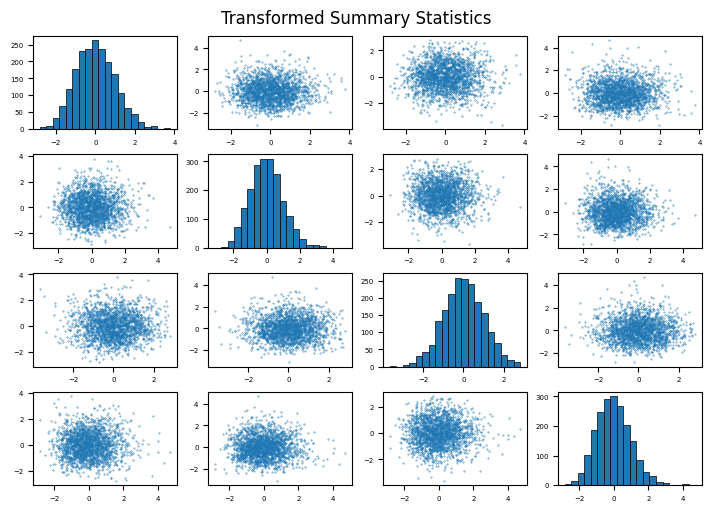

In [63]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x], wass_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

<AxesSubplot: >

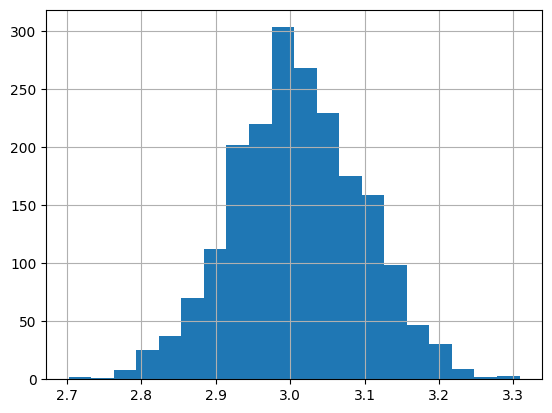

In [20]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 20)

(array([  9.,  24.,  52., 139., 187., 268., 308., 280., 222., 205., 129.,
         81.,  45.,  21.,  12.,  11.,   2.,   3.,   1.,   1.]),
 array([2.76860403, 2.80135999, 2.83411595, 2.86687192, 2.89962788,
        2.93238384, 2.96513981, 2.99789577, 3.03065174, 3.0634077 ,
        3.09616366, 3.12891963, 3.16167559, 3.19443155, 3.22718752,
        3.25994348, 3.29269944, 3.32545541, 3.35821137, 3.39096733,
        3.4237233 ]),
 <BarContainer object of 20 artists>)

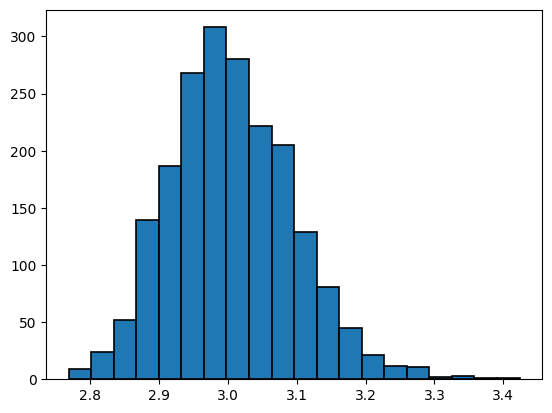

In [36]:
plt.hist(original_train_summary_statistics[:,0], bins = 20, edgecolor='black', linewidth=1.2)

In [18]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-300]
mixture_obj_seq

[GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-0

In [19]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        mean_mixture_obj = mixture_obj.means_
        sigma_mixture_obj = mixture_obj.covariances_
        weights_mixture_obj = mixture_obj.weights_
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

In [20]:
def summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    cov = np.cov(np.array(transformed_summary_statistics).T)
    sample_variance = cov + (np.eye(cov.shape[0]) * 5 * 1e-7)
    return sample_mean, sample_variance

In [21]:
def mean_adjustment_summary_statistics(adjusted_theta, mixture_obj_seq, num_samples, num_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = sample_mean + np.diag(scipy.linalg.sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [22]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def unbiased_log_likelihood(theta):
    ss = summary_statistics(theta, num_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1

    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    return u_est_log_likelihood

def prior_gamma(gamma, sigma_latent, num_latent): 
    log_prior = multivariate_normal.logpdf(gamma, cov= sigma_latent * np.identity(num_latent))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, num_samples, num_datasets, actual_summary_statistics, mixture_obj_seq):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_variance = mean_adj_ss[1]

    # mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(sample_variance)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    part1 = (Gamma - mean_nuissance).T @ my_inv(variance_nuissance) @ (Gamma - mean_nuissance)
    nuissance_mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(variance_nuissance)[1] - part1
    # nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [21]:
Sigma_0 = np.array([[0.00354862371705708,0.0100432715000140,-0.00892228604398757,-0.0115360428708387],
                   [0.0100432715000140,0.0583090115606533,-0.000835188303313756,-0.0757252081004190],
                   [-0.00892228604398757,-0.000835188303313756,0.0653624479615574,0.0107535785728523],
                   [-0.0115360428708387,-0.0757252081004190,0.0107535785728523,0.167430224841150]])
Sigma_0_inv = scipy.linalg.inv(Sigma_0)
l_0 = scipy.linalg.sqrtm(Sigma_0_inv)
l_0

array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
       [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
       [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
       [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

In [31]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                rng = np.random.default_rng()
                theta_0_samples = rng.multivariate_normal(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (4 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (2 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (2.25 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    delta_0 = (1 * np.exp(theta_tilde_0[3]) + 0) / (1 + np.exp(theta_tilde_0[3]))

                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    ss_0 = summary_statistics(theta_0, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_variance_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(sample_variance_0))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_0) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_0) @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                rng = np.random.default_rng()
                theta_q_samples = rng.multivariate_normal(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (4 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (2 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (2.25 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    delta_q = (1 * np.exp(theta_tilde_q[3]) + 0) / (1 + np.exp(theta_tilde_q[3]))

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    ss_q = summary_statistics(theta_q, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_variance_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(sample_variance_q))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_q) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

      
                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [24]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[2.96978227, 1.45609898, 0.4837584 , 2.00723605]])

In [25]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([0.49772725, 0.26557537, 0.34368967, 0.81164569])

In [32]:
# Set hyperparameters
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|                                                                            | 1/5000 [08:06<674:59:50, 486.10s/it]

LB -2677.3050294839154


  0%|                                                                            | 2/5000 [17:17<728:10:09, 524.49s/it]

LB -2517.6392559650208


  0%|                                                                            | 3/5000 [26:22<740:47:08, 533.69s/it]

LB -2515.275141029983


  0%|                                                                            | 4/5000 [33:20<677:40:15, 488.31s/it]

LB -2147.4368236087535


  0%|                                                                            | 5/5000 [39:23<614:51:02, 443.14s/it]

LB -2268.489370302831


  0%|                                                                            | 6/5000 [44:10<540:50:46, 389.88s/it]

LB -2030.4340289614058


  0%|                                                                            | 7/5000 [48:41<486:56:36, 351.09s/it]

LB -2123.950400944608


  0%|                                                                            | 8/5000 [53:59<472:04:41, 340.44s/it]

LB -1842.8853749814384


  0%|▏                                                                           | 9/5000 [59:34<469:45:29, 338.84s/it]

LB -1931.1705186008785


  0%|▏                                                                        | 10/5000 [1:04:42<456:14:38, 329.15s/it]

LB -2035.803659704356


  0%|▏                                                                        | 11/5000 [1:10:27<463:00:49, 334.10s/it]

LB -1993.8428456524334


  0%|▏                                                                        | 12/5000 [1:16:25<472:58:51, 341.37s/it]

LB -1852.1083960626293


  0%|▏                                                                        | 13/5000 [1:21:17<452:23:56, 326.58s/it]

LB -1724.631719480319


  0%|▏                                                                        | 14/5000 [1:26:22<443:08:33, 319.96s/it]

LB -1765.488859689489


  0%|▏                                                                        | 14/5000 [1:28:57<528:00:56, 381.24s/it]


KeyboardInterrupt: 

In [33]:
best_lambda = np.array([np.array([ 3.19810092,  0.09903016,  1.84708307, -0.31620551]),
       np.array([41.94118703, -8.53190355,  5.26819136, -1.2521479 ,  8.1421152 ,
              -1.12904861,  2.65895337,  4.05549818, -0.29774536,  3.31271867])],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

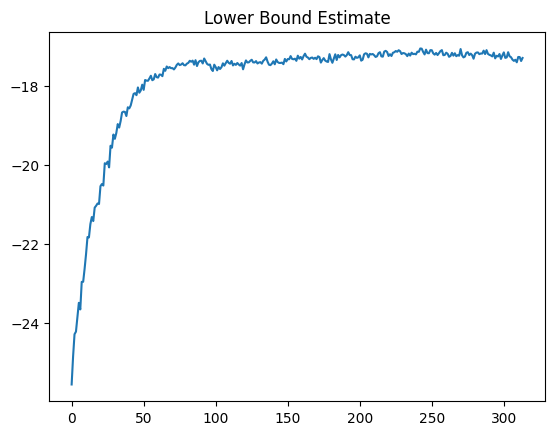

In [44]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

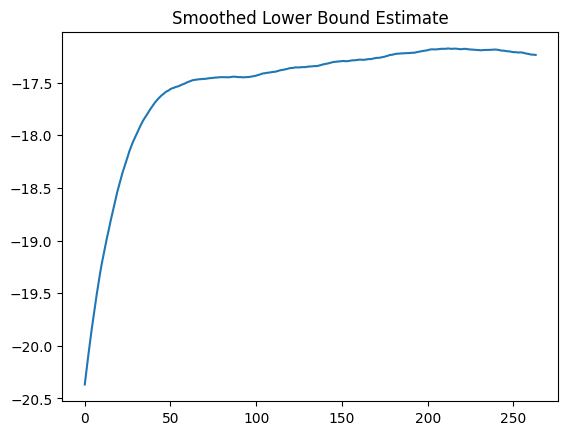

In [45]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [34]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 10000)
best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.21788474, 8.328837  , 1.21265657, 7.90678226])

Text(0.5, 1.0, 'Posterior density of alpha')

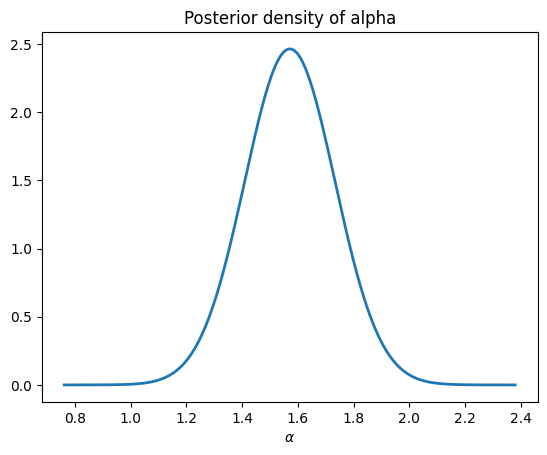

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

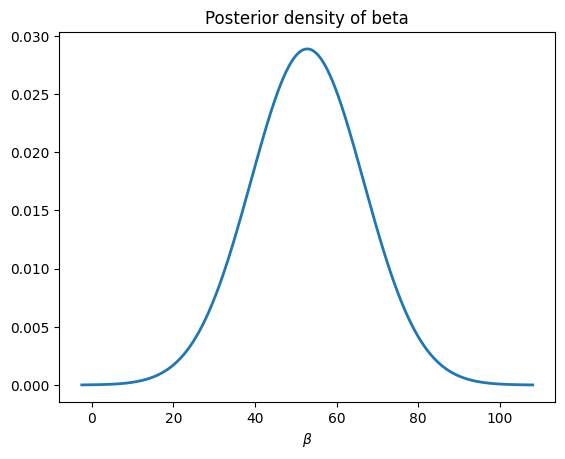

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

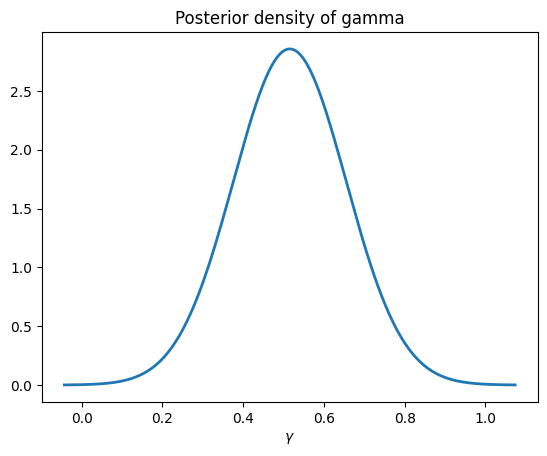

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 20000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0]-0)/(5-true_theta[0])), np.log((true_theta[1]-0)/(2-true_theta[1])), np.log((true_theta[2]-0)/(3-true_theta[2])), np.log((true_theta[3]-0)/(1-true_theta[3]))])

    alpha = (5 * np.exp(theta_tilde[0]) + 0) / (1 + np.exp(theta_tilde[0]))
    beta = (2 * np.exp(theta_tilde[1]) + 0) / (1 + np.exp(theta_tilde[1]))
    gamma = (3 * np.exp(theta_tilde[2]) + 0) / (1 + np.exp(theta_tilde[2]))
    delta = (1 * np.exp(theta_tilde[3]) + 0) / (1 + np.exp(theta_tilde[3]))

    theta = np.array([alpha, beta, gamma, delta])

    # GENERATE GAMMA
    ss = summary_statistics(theta, mixture_obj_seq, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]

    # Find mean and variance for p(gamma | theta, obs)

    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(sample_variance))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets, actual_summary_statistics)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = random.uniform(0, 1)
            if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))    
            else:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = (5 * np.exp(theta_proposal_tilde[0]) + 0) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (2 * np.exp(theta_proposal_tilde[1]) + 0) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = (3 * np.exp(theta_proposal_tilde[2]) + 0) / (1 + np.exp(theta_proposal_tilde[2]))
        delta_prop = (1 * np.exp(theta_proposal_tilde[3]) + 0) / (1 + np.exp(theta_proposal_tilde[3]))

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        # GENERATE GAMMA
        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]

        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(sample_variance))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, actual_summary_statistics)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)